# 7. Supplementary Figure 4

This notebook is used to create the panels of Supplementary Figure 4.

Before starting, use 1.Preprocessing notebook to generate:
- SC2_normalized.h5ad - Normalized single-cell data

Before starting, download data available at Metabolights [www.ebi.ac.uk/metabolights/MTBLS11236], study identifier MTBLS11236 and move to data folder.
- SC2_overlap_analysis.csv - Ablation marks data
- SC5_SpaceM_data.h5ad - Single-cell lipidomics data from SpaceM method paper [https://www.nature.com/articles/s41592-021-01198-0].

In [1]:
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import scanpy as sc
from scipy import stats
from anndata import read_h5ad
from itertools import combinations
from tqdm import tqdm

import sys
sys.path.insert(0, '../functions/')
import utils
import pl

### Set plot style

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats=['retina']
sns.set(rc={'figure.figsize':(5, 5),
            'legend.frameon':False},
        style='ticks',
        context='talk')

# Render figures with higher resolution.
plt.rcParams['figure.dpi']=200
# Save with transparent regions white background.
plt.rcParams['savefig.facecolor']='white'

### Set color palette

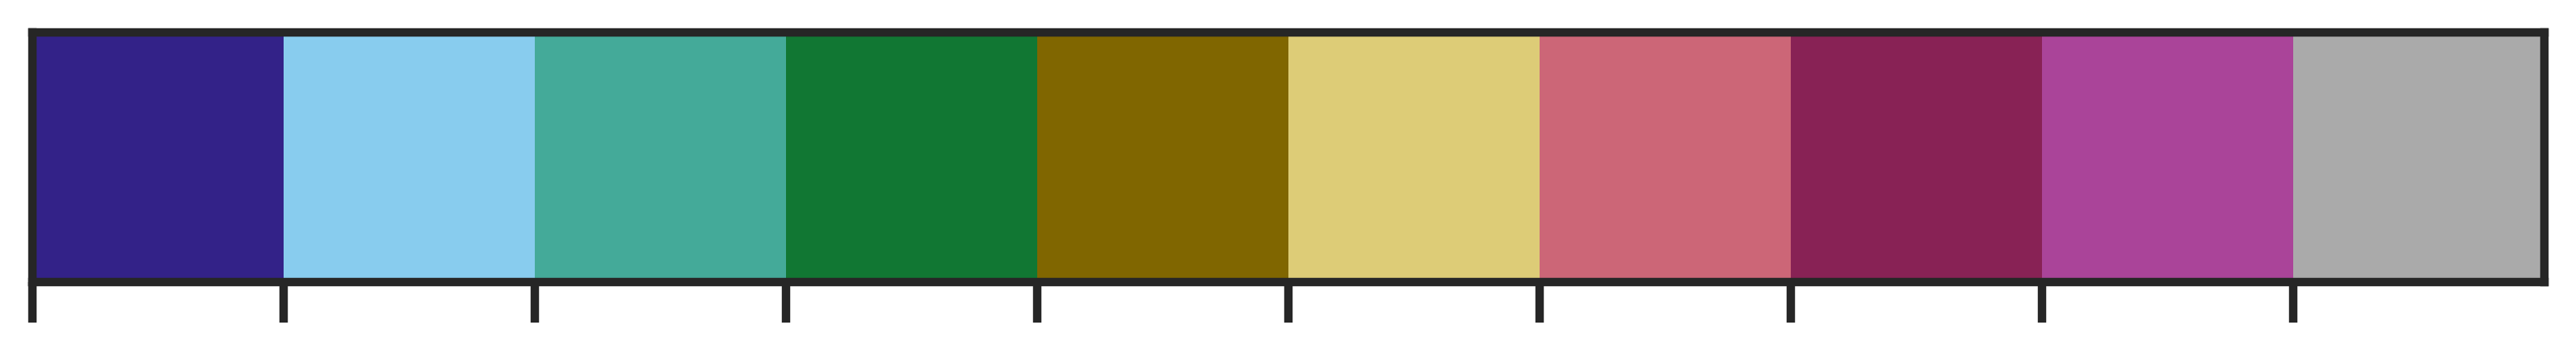

In [3]:
#color palette
palette = [(51,34,136),(136,204,238),(68,170,153),(17,119,51),(128,102,0),(221,204,119),(204,102,119),(136,34,85),(170,68,153),(170,170,170)]
palette = [(e[0]/255.0, e[1]/255.0, e[2]/255.0) for e in palette]
cmap = ListedColormap(palette)
sns.color_palette(palette=None,as_cmap=True)
sns.palplot(palette)

## Panel A
NCI-60 and HeLa microscopy cells.

## Panel B

### Set paths

In [4]:
#input
data_dir = Path(r'../data')
anndata_path = data_dir / 'SC2_normalized.h5ad'

#output
plots_path =  Path(r'../') / 'figures' / 'supplementary_figure_4'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [5]:
#load anndata file
adata =  sc.read_h5ad(anndata_path)
adata.raw = adata

#calculate cell size
adata.obs['cell_area_um2'] = adata.obs['cell_area'] * (0.64**2) #pixel size

### Violin plot

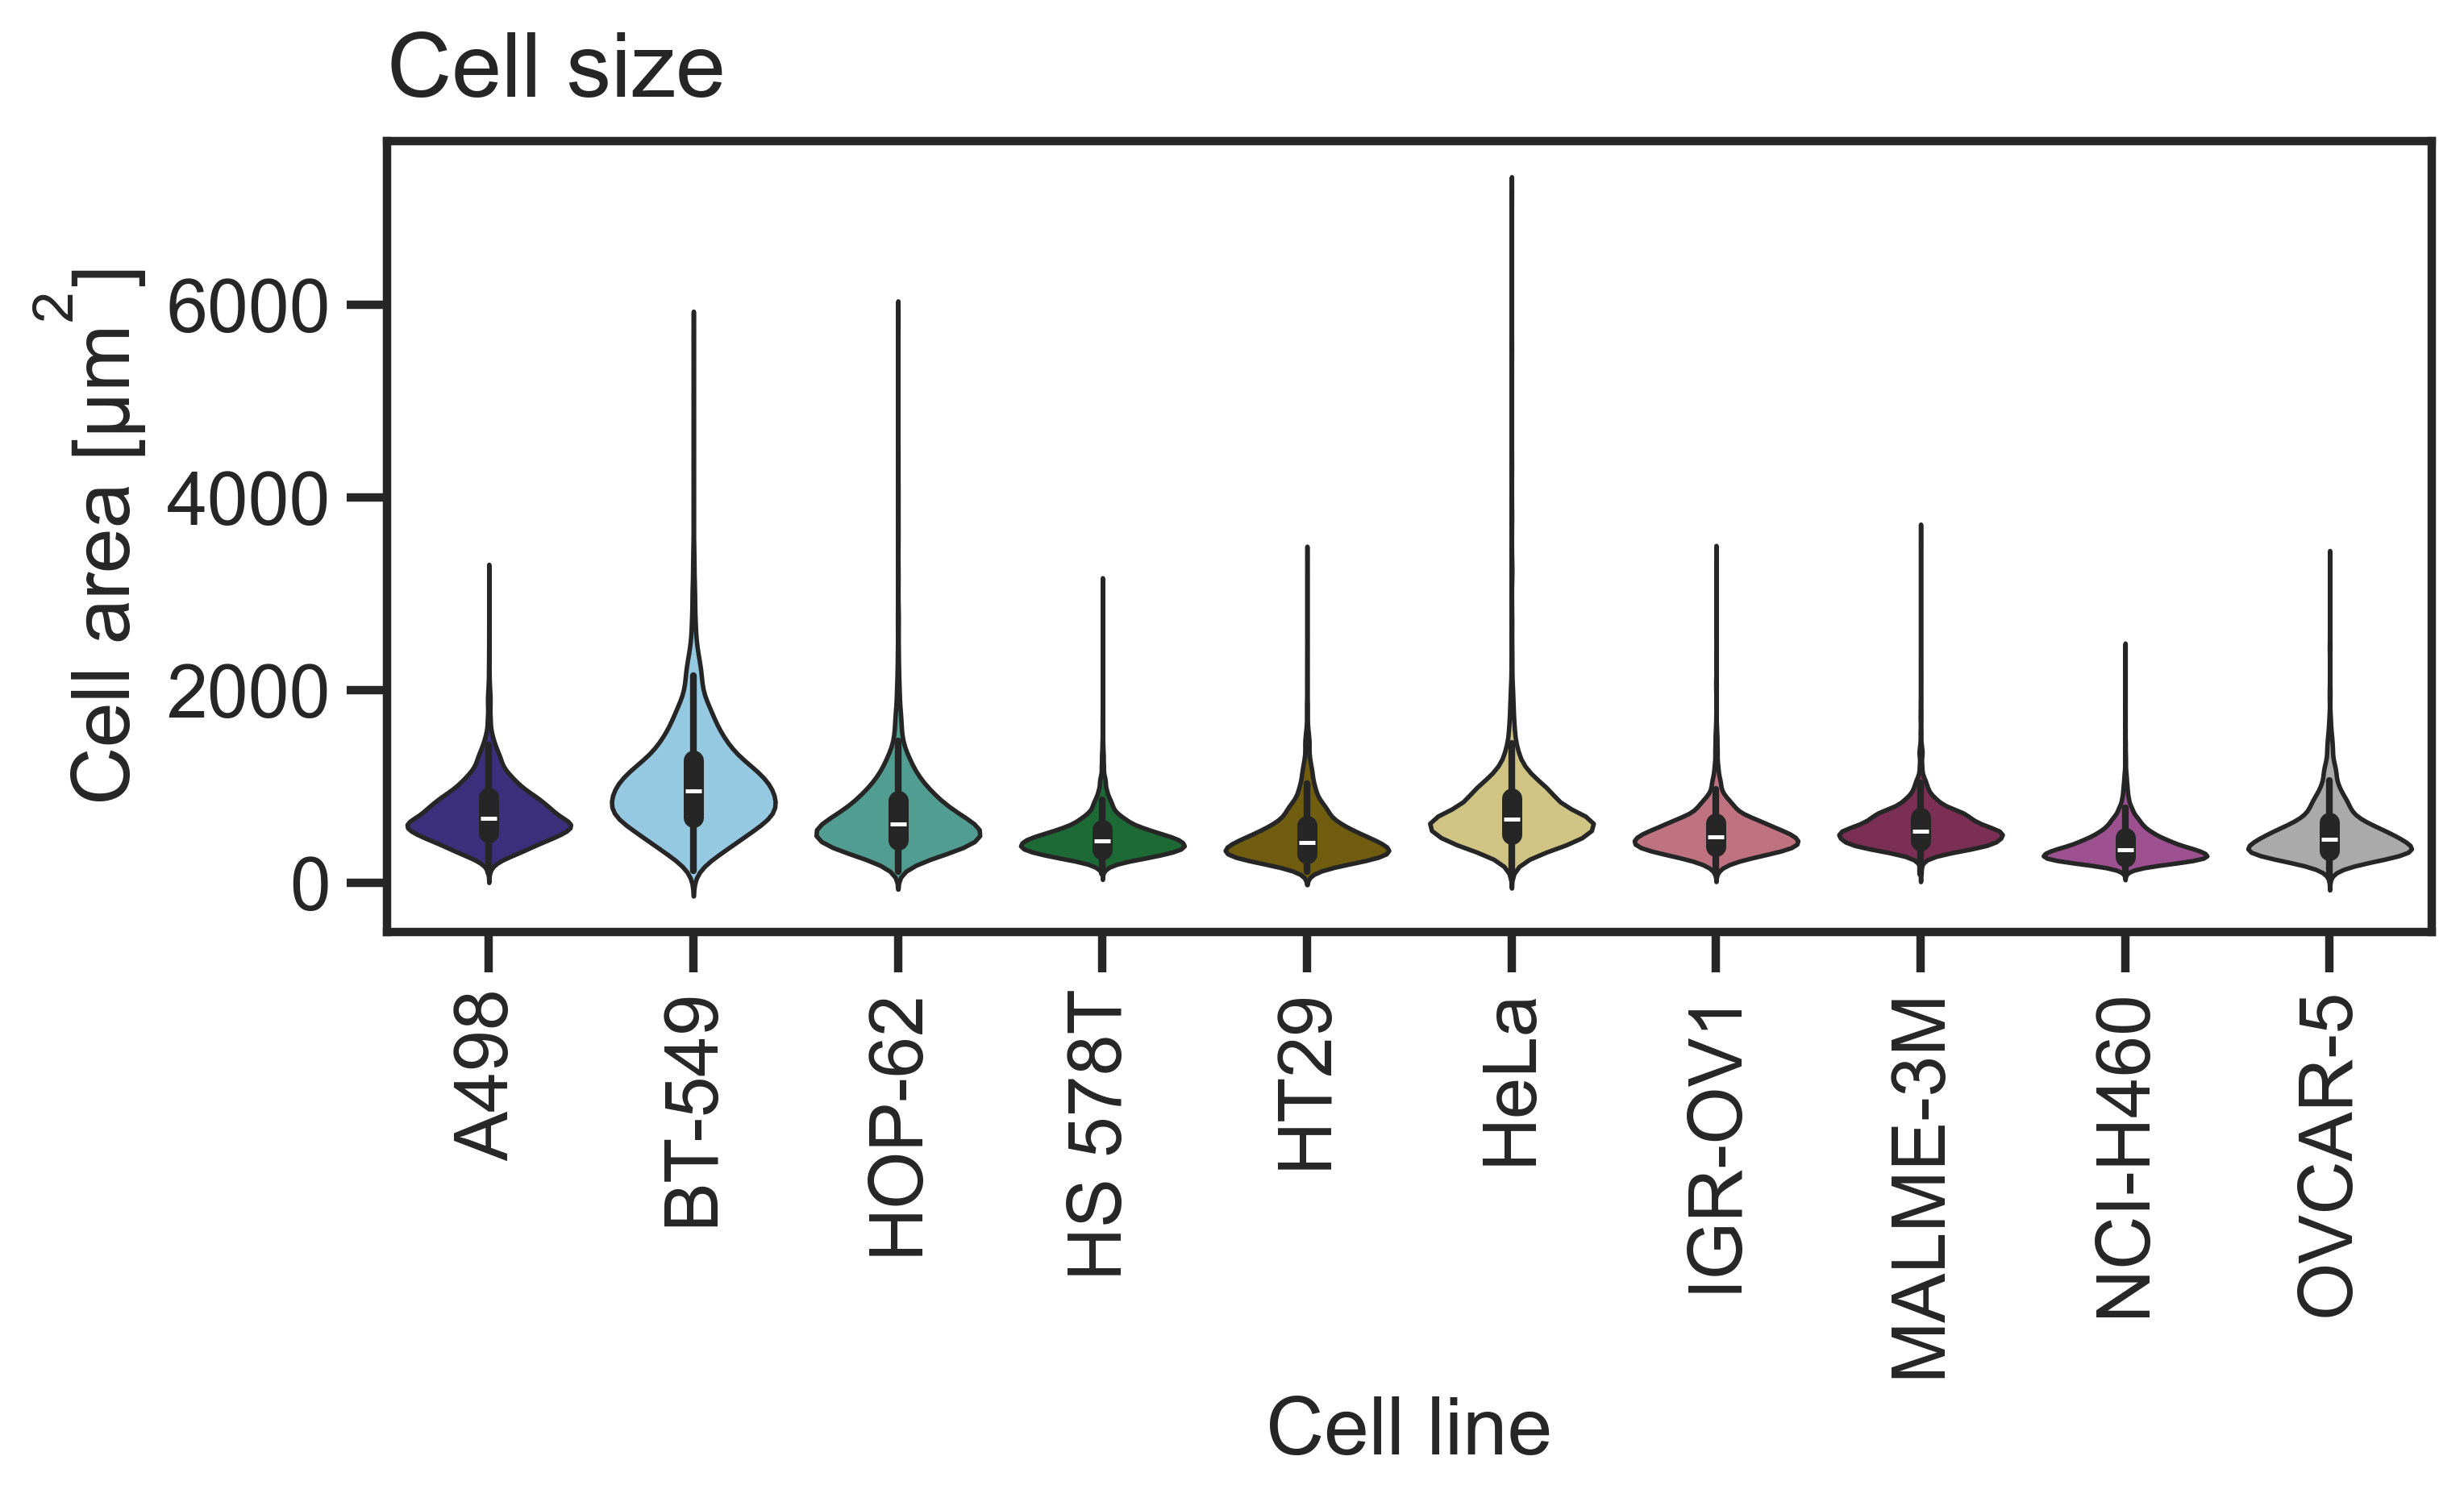

In [6]:
plt.figure(figsize=(8,5))
p = sns.violinplot(x='CellLine', 
                   y='cell_area_um2', 
                   data=adata.obs, 
                   hue='CellLine',
                   palette=palette, 
                   legend=False,
                   linewidth=1)

plt.ylabel(r'Cell area [$\mathregular{\mu m^2}$]')
plt.xlabel('')
plt.xlabel("Cell line")
plt.xticks(rotation=90)
plt.title("Cell size", size=20, x=0, ha="left", va="bottom")
plt.tight_layout()

plt.savefig(plots_path / 'panel_B.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_B.svg', bbox_inches='tight')

## Panel C

### Set paths

In [7]:
#input
data_dir = Path(r'../data')
data_path = data_dir / 'SC2_overlap_analysis.csv'

#output
plots_path =  Path(r'../') / 'figures' / 'supplementary_figure_4'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [8]:
overlap_df = pd.read_csv(data_path)

### Boxplots
AM versus Cell area

/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


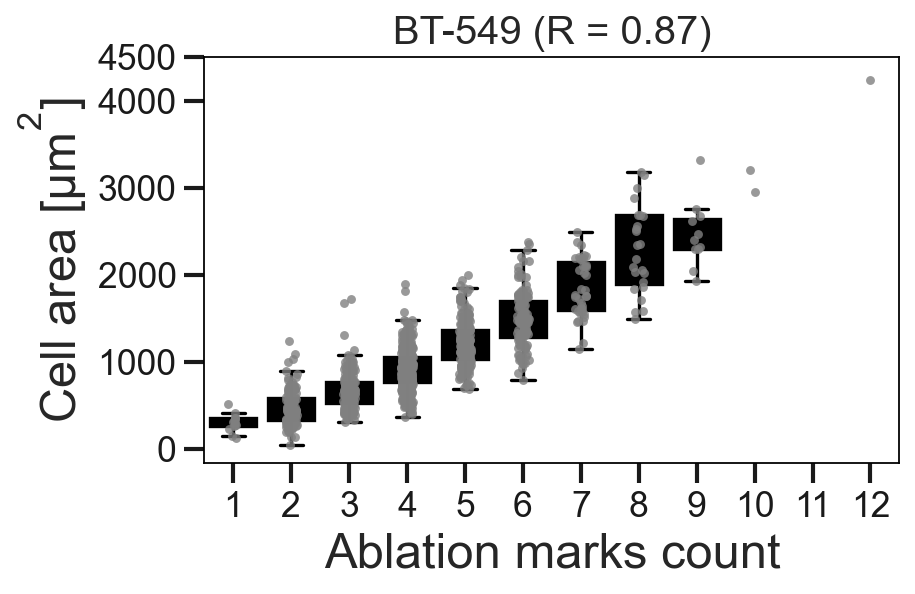

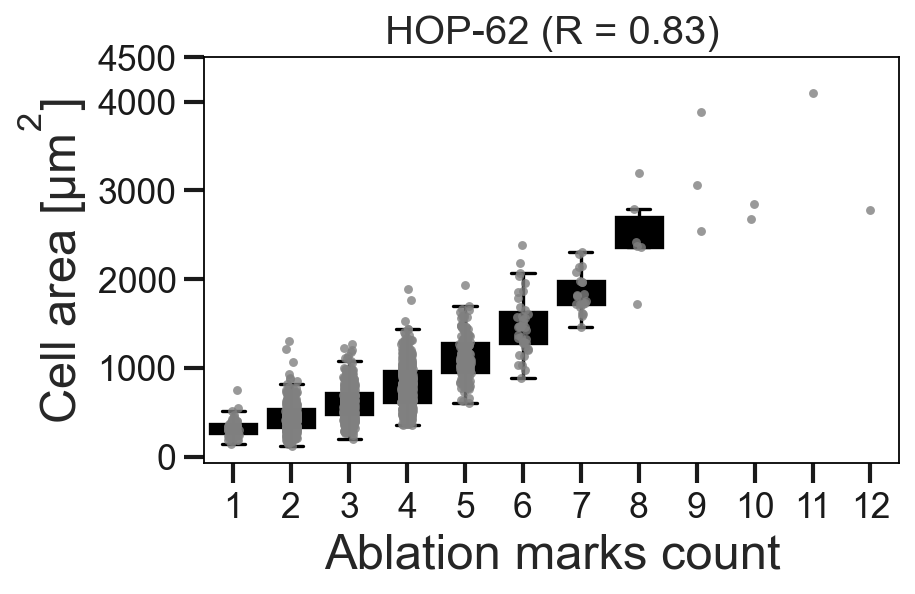

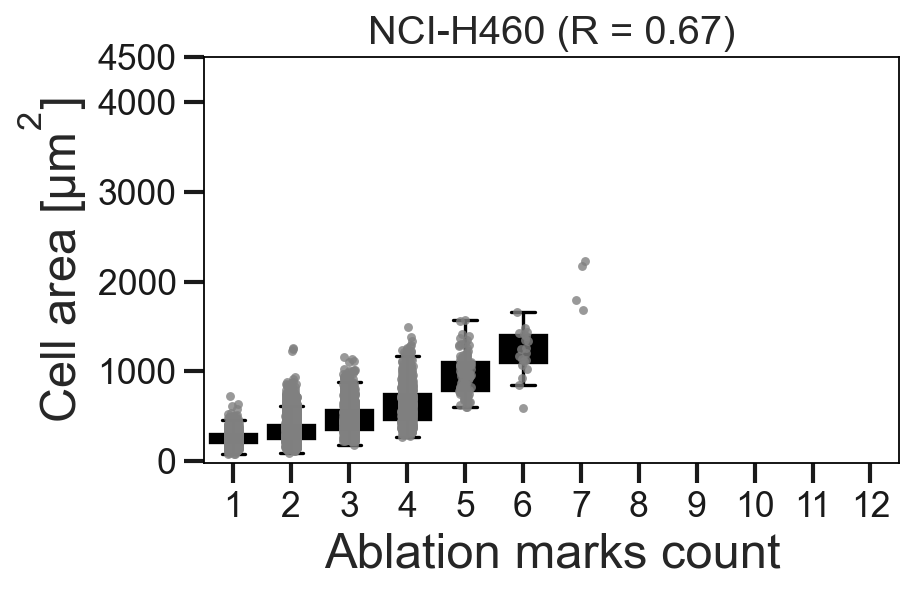

In [9]:
cell =  'condition'
sc.set_figure_params(fontsize=15)
x_order = list(range(1, 13))
for condition in overlap_df[cell].unique():
    subset = overlap_df[overlap_df[cell] == condition].copy()
    # Pearson correlation
    try:
        pearson_res = stats.pearsonr(subset['am_id_count'].astype(float), subset['cell_area_um2'])
        stat_text = f'R = {pearson_res.statistic:.2f}'
    except Exception:
        stat_text = 'R = NA, p = NA'

    # Identify which am_id_count have ≥ 5 observations
    valid_counts = subset['am_id_count'].value_counts()
    valid_categories = valid_counts[valid_counts >= 5].index

    plt.figure(figsize=(6, 4))
    # Boxplot: Only for categories with ≥ 5
    sns.boxplot(
        x='am_id_count',
        y='cell_area_um2',
        data=subset[subset['am_id_count'].isin(valid_categories)],
        order=x_order,
        color=palette[0],
        width=0.8,
        fliersize=0,
        boxprops=dict(alpha=1, linewidth=1.5,color='black'),
        whiskerprops=dict(linewidth=1.5, color='black'),
        capprops=dict(linewidth=1.5, color='black'),
        medianprops=dict(linewidth=1.5, color='black'))

    # Jitter (strip) plot for all data
    sns.stripplot(
        x='am_id_count',
        y='cell_area_um2',
        data=subset,
        order=x_order,
        color='gray',
        jitter=True,
        size=4,
        alpha=0.8)

    plt.title(f'{condition} ({stat_text})', fontsize=18)
    plt.ylabel(r'Cell area [$\mathregular{\mu m^2}$]', fontsize=22)
    plt.xlabel('Ablation marks count', fontsize=22)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.yticks([0, 1000, 2000, 3000, 4000, 4500])
    plt.grid(False)
    plt.minorticks_off()
    plt.tight_layout()
    
    plt.savefig(plots_path / f'panel_C_cell_area_{condition}.png', bbox_inches='tight')
    plt.savefig(plots_path / f'panel_C_cell_area_{condition}.svg', bbox_inches='tight')

AM vs Number of metabolites 

/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


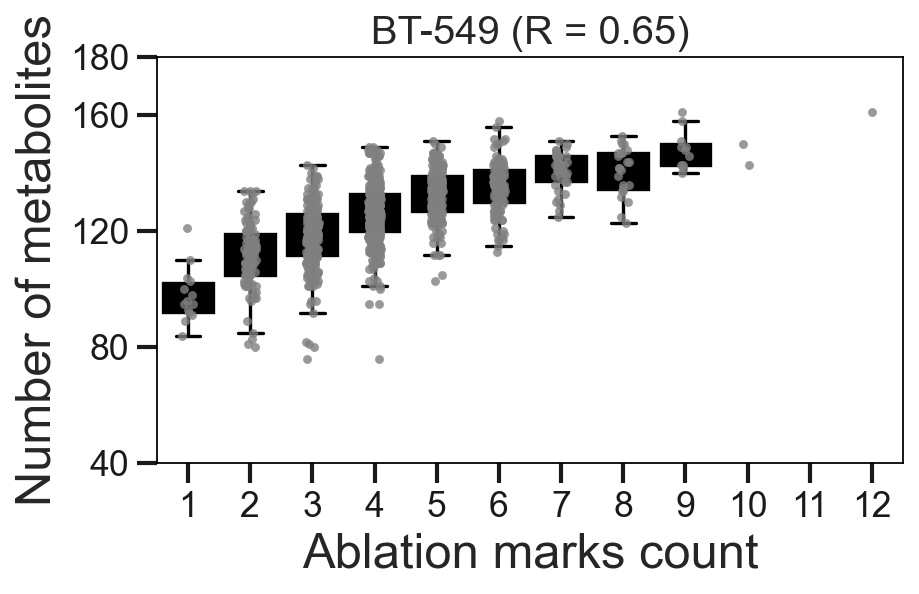

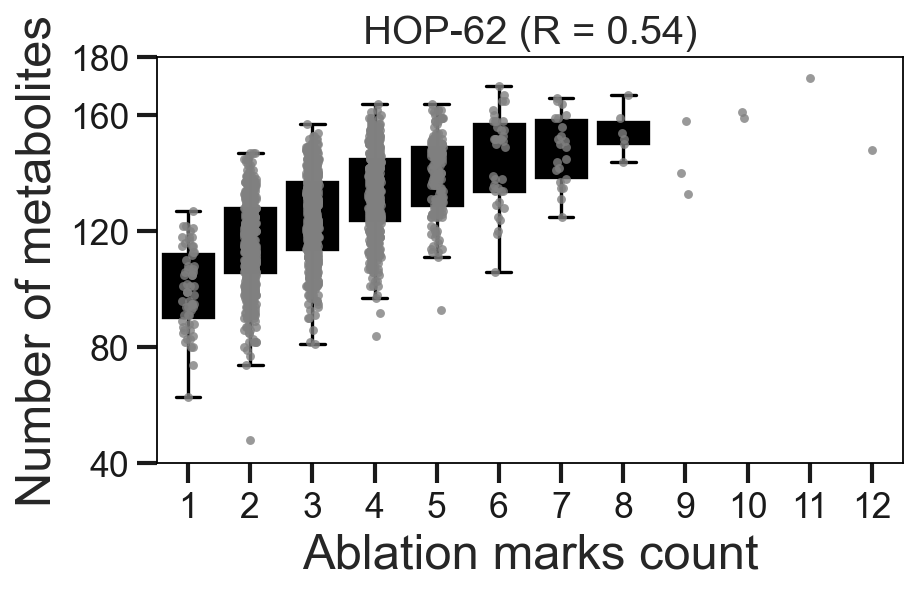

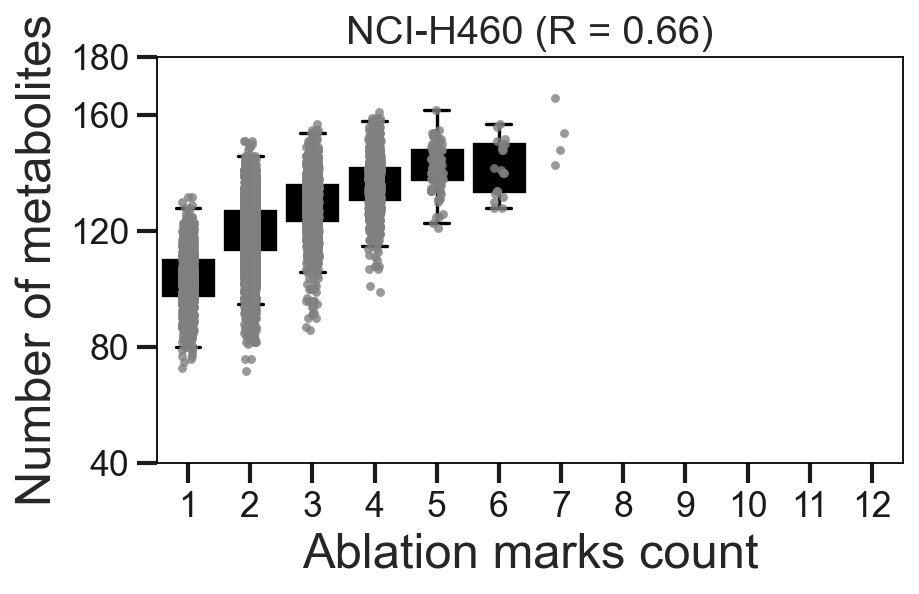

In [10]:
cell =  'condition'
sc.set_figure_params(fontsize=15)
x_order = list(range(1, 13))
for condition in overlap_df[cell].unique():
    subset = overlap_df[overlap_df[cell] == condition].copy()
    # Pearson correlation
    try:
        pearson_res = stats.pearsonr(subset['am_id_count'].astype(float), subset['n_genes'])
        stat_text = f'R = {pearson_res.statistic:.2f}'
    except Exception:
        stat_text = 'R = NA, p = NA'

    # Identify which am_id_count have ≥ 5 observations
    valid_counts = subset['am_id_count'].value_counts()
    valid_categories = valid_counts[valid_counts >= 5].index

    plt.figure(figsize=(6, 4))
    # Boxplot: Only for categories with ≥ 5
    sns.boxplot(
        x='am_id_count',
        y='n_genes',
        data=subset[subset['am_id_count'].isin(valid_categories)],
        order=x_order,
        color=palette[0],
        width=0.8,
        fliersize=0,
        boxprops=dict(alpha=1, linewidth=1.5,color='black'),
        whiskerprops=dict(linewidth=1.5, color='black'),
        capprops=dict(linewidth=1.5, color='black'),
        medianprops=dict(linewidth=1.5, color='black')
    )

    # Jitter (strip) plot for all data
    sns.stripplot(
        x='am_id_count',
        y='n_genes',
        data=subset,
        order=x_order,
        color='gray',
        jitter=True,
        size=4,
        alpha=0.8
    )

    plt.title(f'{condition} ({stat_text})', fontsize=18)
    plt.ylabel(r'Number of metabolites', fontsize=22)
    plt.xlabel('Ablation marks count', fontsize=22)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.yticks([40,80,120,160,180])
    plt.grid(False)
    plt.minorticks_off()
    plt.tight_layout()
    
    plt.savefig(plots_path / f'panel_C_ions_{condition}.png', bbox_inches='tight')
    plt.savefig(plots_path / f'panel_C_ions_{condition}.svg', bbox_inches='tight')

## Panel D

### Set paths

In [11]:
#input
data_dir = Path(r'../data')
anndata_path = data_dir / 'SC2_normalized.h5ad'

#output
plots_path =  Path(r'../') / 'figures' / 'supplementary_figure_4'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [12]:
#load anndata file
adata =  sc.read_h5ad(anndata_path)
adata.raw = adata

### Boxplot

In [13]:
# Get unique cell lines
cell_lines = adata.obs['CellLine'].unique()
max_n = len(cell_lines)

# Container for results
results = []

# Iterate over n from 2 to max_n
for n in range(2, max_n + 1):
    combs = list(combinations(cell_lines, n))
    for comb in tqdm(combs, desc=f"Processing combinations of {n} cell lines"):
        # Subset to cells from the selected cell lines
        subset = adata[adata.obs['CellLine'].isin(comb)]
        
        # Track detection per cell line
        detection_per_line = []

        for cl in comb:
            cl_data = subset[subset.obs['CellLine'] == cl].X
            # For sparse matrix support
            if hasattr(cl_data, 'toarray'):
                cl_data = cl_data.toarray()
            # Detected if >0 in 90% of cells
            detected = (cl_data > 0).sum(axis=0) >= (0.99 * cl_data.shape[0])
            detection_per_line.append(detected)

        # Stack boolean arrays and check for metabolites detected in ALL lines
        all_detected = np.logical_and.reduce(detection_per_line)
        percent_detected = all_detected.sum() / all_detected.size * 100
        
        results.append({'n_cell_lines': n, 'percent_detected': percent_detected})

# Convert to DataFrame
results_df = pd.DataFrame(results)

Processing combinations of 2 cell lines: 100%|██| 45/45 [00:01<00:00, 28.70it/s]
Processing combinations of 3 cell lines: 100%|█| 120/120 [00:05<00:00, 21.40it/s
Processing combinations of 4 cell lines: 100%|█| 210/210 [00:12<00:00, 17.04it/s
Processing combinations of 5 cell lines: 100%|█| 252/252 [00:17<00:00, 14.15it/s
Processing combinations of 6 cell lines: 100%|█| 210/210 [00:17<00:00, 12.03it/s
Processing combinations of 7 cell lines: 100%|█| 120/120 [00:11<00:00, 10.70it/s
Processing combinations of 10 cell lines: 100%|███| 1/1 [00:00<00:00,  8.37it/s]


/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


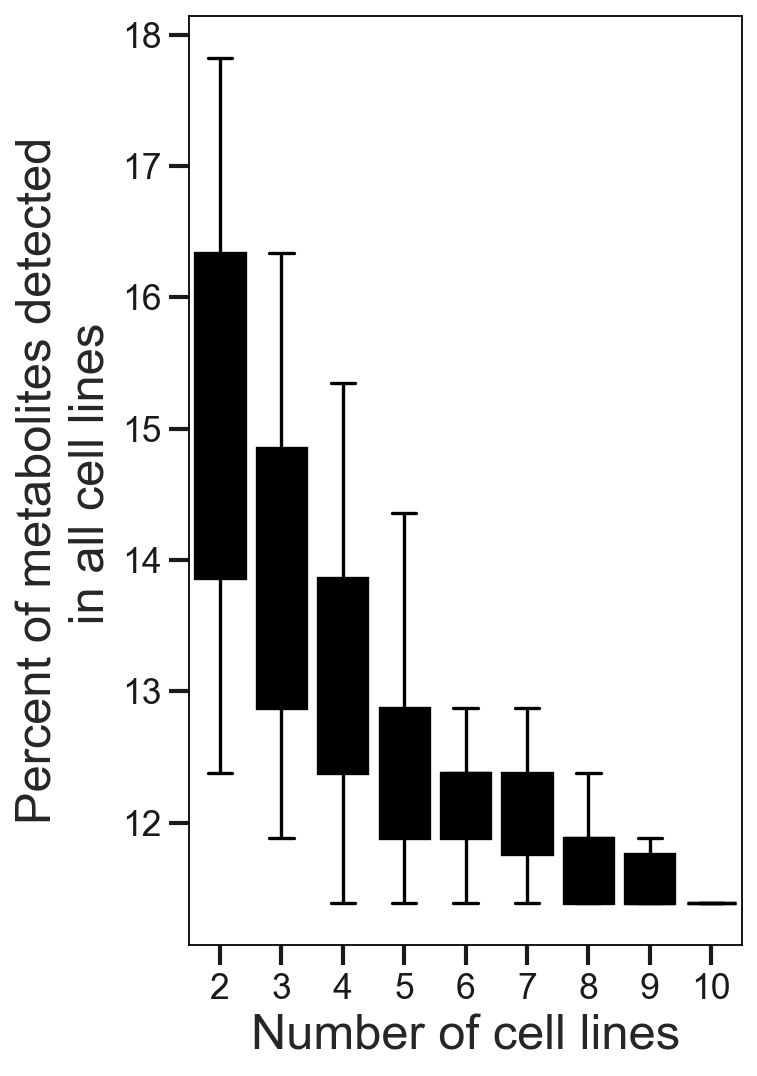

In [14]:
plt.figure(figsize=(5, 7))
sns.boxplot(
    x='n_cell_lines',
    y='percent_detected',
    data=results_df,
    color=palette[0],
    width=0.8,
    fliersize=0,
    boxprops=dict(alpha=1, linewidth=1.5,color='black'),
    whiskerprops=dict(linewidth=1.5, color='black'),
    capprops=dict(linewidth=1.5, color='black'),
    medianprops=dict(linewidth=1.5, color='black'))
plt.ylabel(f'Percent of metabolites detected\n in all cell lines', fontsize=22)
plt.xlabel('Number of cell lines', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.grid(False)
plt.minorticks_off()
plt.tight_layout()

plt.savefig(plots_path / f'panel_D.png', bbox_inches='tight')
plt.savefig(plots_path / f'panel_D.svg', bbox_inches='tight')

## Panel E
Venn diagram created using Inkscape with the column 'detection' in the 'SC2_metabolite_IDs.csv' file

## Panel F

### Set paths

In [15]:
#input
data_dir = Path(r'../data')
anndata_path = data_dir / 'SC2_normalized.h5ad'

#output
plots_path =  Path(r'../') / 'figures' / 'supplementary_figure_4'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [16]:
#load anndata file
adata =  sc.read_h5ad(anndata_path)
adata.raw = adata

In [17]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, random_state=12345)
sc.tl.umap(adata, random_state=12345) 
adata.obs[['UMAP1', 'UMAP2']] = adata.obsm['X_umap']

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### UMAP

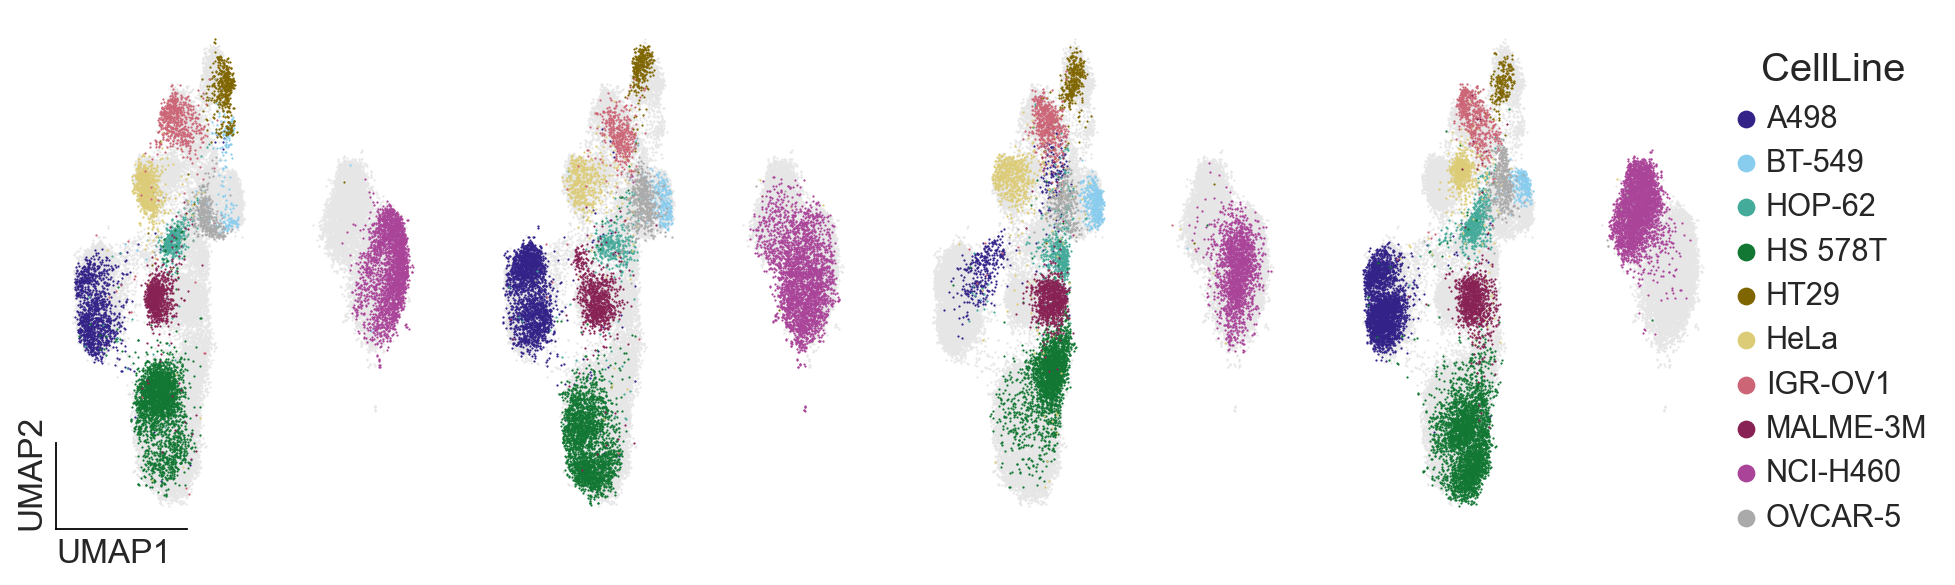

In [18]:
f = pl.highlight_scatterplot(
    data=adata,
    obsm_key='X_umap',
    hue='CellLine', 
    background_color='#e6e6e6ff',
    palette=palette,
    col='replicate',
    height=4.5,
    aspect=0.65,
    #col_wrap=2,
    decorate_titles=False,
    trim_axes=True,
    scatter_kwargs={'s':1})

f.add_legend(markerscale=8)
f.set_titles(col_template='')

plt.savefig(plots_path / 'panel_F.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_F.svg', bbox_inches='tight')

## Panel G

### Set paths

In [19]:
#input
data_dir = Path(r'../data')
anndata_path1= data_dir / 'SC2_normalized.h5ad'
anndata_path2= data_dir / 'SC5_SpaceM_data.h5ad'

#output
plots_path =  Path(r'../') / 'figures' / 'supplementary_figure_4'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [20]:
#load anndata file
adata1 =  sc.read_h5ad(anndata_path1)
adata1.raw = adata1

adata2 =  sc.read_h5ad(anndata_path2)
adata2.raw = adata2

/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/anndata/compat/__init__.py:329: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/anndata/compat/__init__.py:329: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [21]:
df1 = pd.DataFrame(adata1.X, index=adata1.obs_names, columns=adata1.var_names)
df1['Group'] = adata1.obs['CellLine'].values
df1['Dataset'] = 'Single-cell metabolomics from NCI-60 cell lines'

df2 = pd.DataFrame(adata2.X, index=adata2.obs_names, columns=adata2.var_names)
condition_map = {
    'U': 'Untreated',
    'F': '+FA',
    'FI': '+FA+IL17A',
    'FIT': '+FA+IL17A+TPCA1'
}
df2['Group'] = adata2.obs['condition'].map(condition_map)
df2['Dataset'] = 'Single cell lipidomics for treated hepatocytes'

combined_df = pd.concat([df1, df2], axis=0)
combined_df = combined_df.dropna(subset=['Group'])

### Boxplot

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_34373/2081107881.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_detailed = combined_df.groupby(['Group', 'Dataset']).apply(per_metabolite_entropy).reset_index(drop=True)


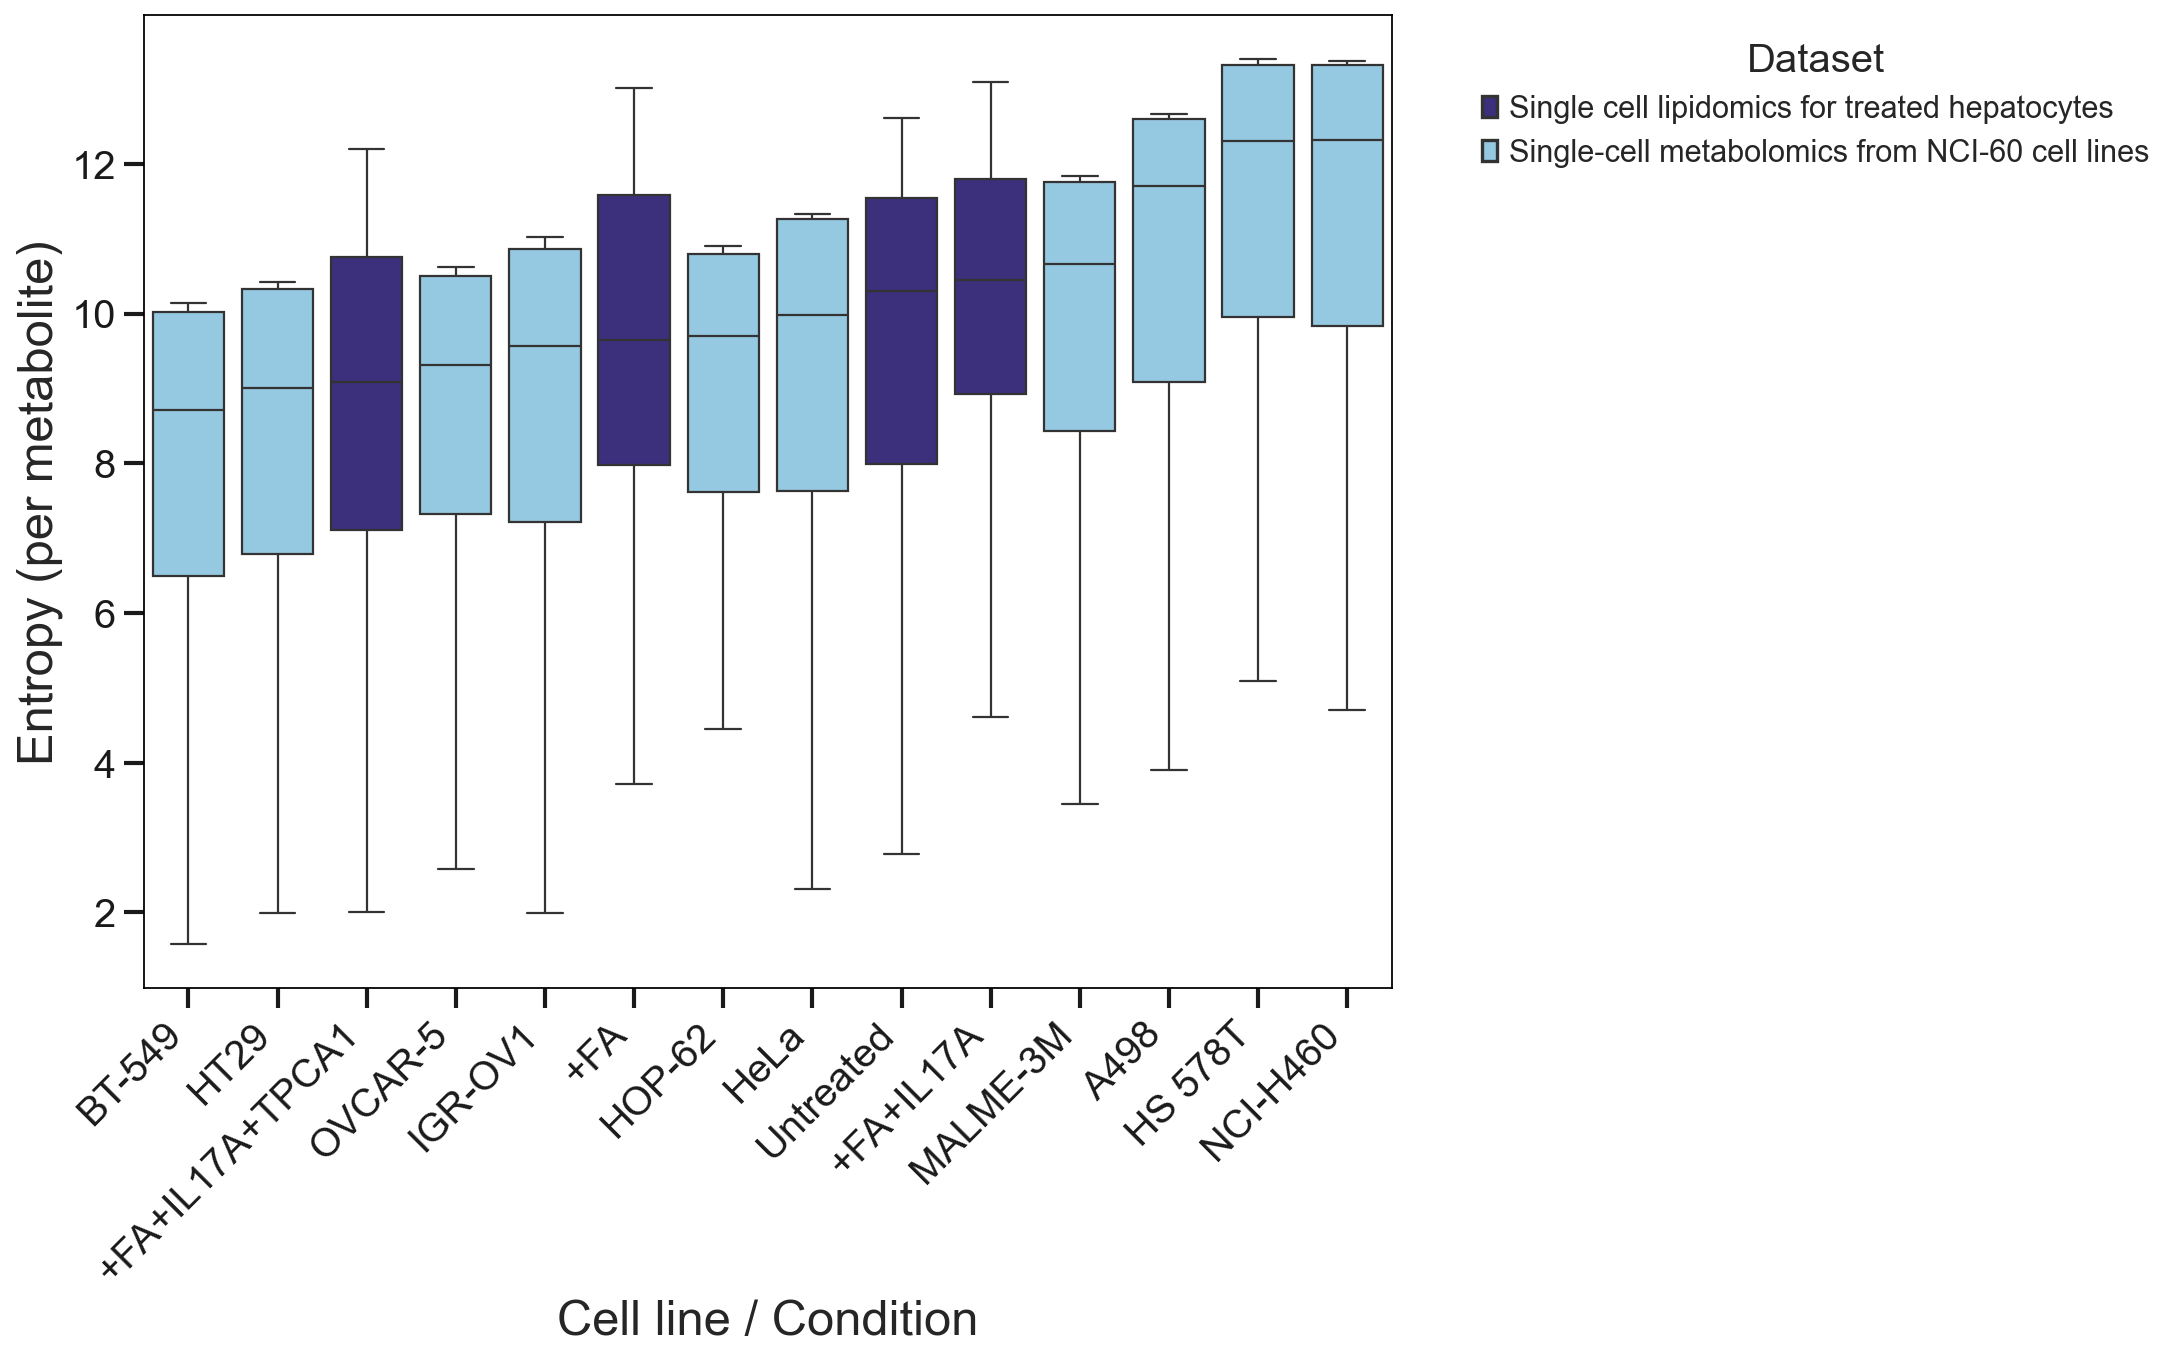

In [22]:
def per_metabolite_entropy(group):
    numeric_df = group.drop(columns=['Group', 'Dataset'], errors='ignore')
    entropies = []
    for metabolite in numeric_df.columns:
        values = numeric_df[metabolite].values
        values = np.clip(values, a_min=0, a_max=None)
        total = values.sum()
        if total > 0:
            prob_dist = values / total
            e = stats.entropy(prob_dist, base=2)
            entropies.append((metabolite, e))
    result = pd.DataFrame(entropies, columns=['Metabolite', 'Entropy'])
    result['Group'] = group['Group'].iloc[0]
    result['Dataset'] = group['Dataset'].iloc[0]
    return result

entropy_detailed = combined_df.groupby(['Group', 'Dataset']).apply(per_metabolite_entropy).reset_index(drop=True)

#Sort by Median Entropy
group_medians = entropy_detailed.groupby('Group')['Entropy'].median().sort_values()
ordered_groups = group_medians.index.tolist()

plt.figure(figsize=(10, 8))
sns.boxplot(data=entropy_detailed,
            x='Group',
            y='Entropy',
            hue='Dataset',
            order=ordered_groups, 
            palette=palette[:2], 
            showfliers=False,
            width=0.8)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Cell line / Condition', fontsize=22)
plt.ylabel('Entropy (per metabolite)', fontsize=22)

plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=18)

plt.grid(False)
plt.minorticks_off()
#plt.tight_layout()

plt.savefig(plots_path / f'panel_G.png', bbox_inches='tight')
plt.savefig(plots_path / f'panel_G.svg', bbox_inches='tight')

## Panel G

### Set path

In [23]:
#input
data_dir = Path(r'../data')
anndata_path = data_dir / 'SC2_normalized.h5ad'

#output
plots_path =  Path(r'../') / 'figures' / 'supplementary_figure_4'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [24]:
#load anndata file
adata =  sc.read_h5ad(anndata_path)
adata.raw = adata

In [25]:
cell_name='HOP-62'

adata = adata[adata.obs.CellLine.eq(cell_name),:]
int_matrix = pd.DataFrame(columns=adata.var_names, data=adata.X, index=adata.obs_names)

### Scatterplots
#### Co-detected

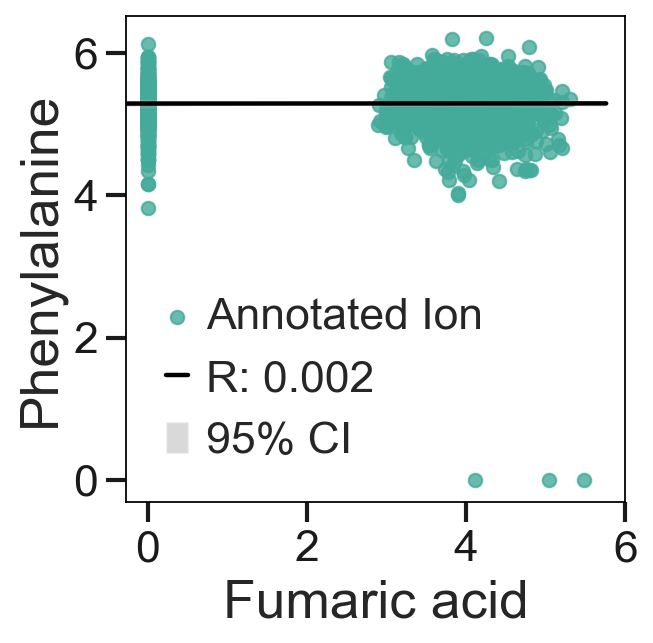

In [26]:
res = stats.pearsonr(int_matrix['C4H4O4-H'], 
                     int_matrix['C9H11NO2-H'],
                     alternative='two-sided')

sc.set_figure_params(fontsize=15)

ax = sns.regplot(data=int_matrix, 
                 x='C4H4O4-H',
                 y='C9H11NO2-H',
                 fit_reg=True,
                 ci=95,
                 line_kws={'lw':'2', 'color':'black'},
                 scatter=True,
                 color=palette[2],
                 truncate=False)

ax.grid(False)
ax.minorticks_off()
ax.legend(labels=['Annotated Ion', f'R: {res.statistic:.3f}', '95% CI'], loc='best', fontsize=20)
plt.xlabel(xlabel=u'Fumaric acid', fontsize=24)
plt.ylabel(ylabel=u'Phenylalanine', fontsize=24)
ax.set_xticks((0,2,4,6))
plt.tick_params(axis='both', which='major', labelsize=20)

plt.savefig(plots_path / 'panel_G_codetected.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_G_codetected.svg', bbox_inches='tight')

#### Positively co-abundant

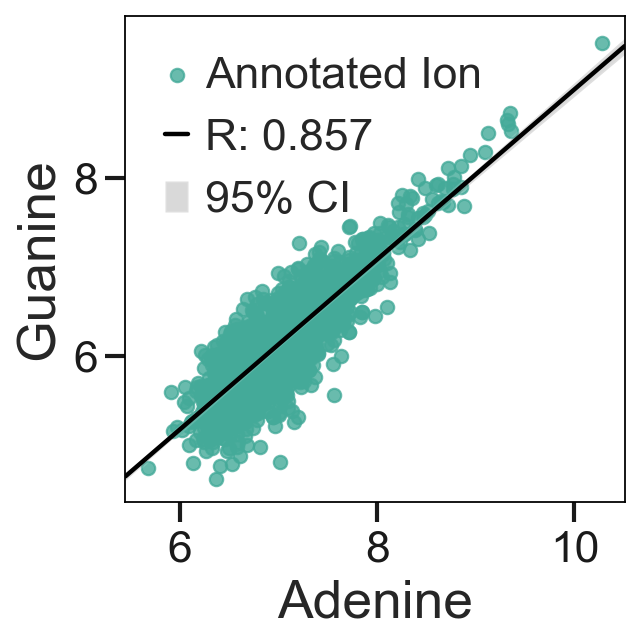

In [27]:
res = stats.pearsonr(int_matrix['C5H5N5-H'], 
                     int_matrix['C5H5N5O-H'], 
                     alternative='two-sided')

sc.set_figure_params(fontsize=15)
ax = sns.regplot(data=int_matrix, 
                 x='C5H5N5-H',
                 y='C5H5N5O-H',
                 fit_reg=True,
                 ci=95,
                 line_kws={'lw':'2', 'color':'black'},
                 scatter=True,
                 color=palette[2],
                 truncate=False)

ax.grid(False)
ax.minorticks_off()
ax.legend(labels=['Annotated Ion', f'R: {res.statistic:.3f}', '95% CI'], loc='best', fontsize=20)
plt.xlabel(xlabel=u'Adenine', fontsize=24)
plt.ylabel(ylabel=u'Guanine', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.savefig(plots_path / 'panel_G_positively.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_G_positively.svg', bbox_inches='tight')

#### Inversely co-abundant

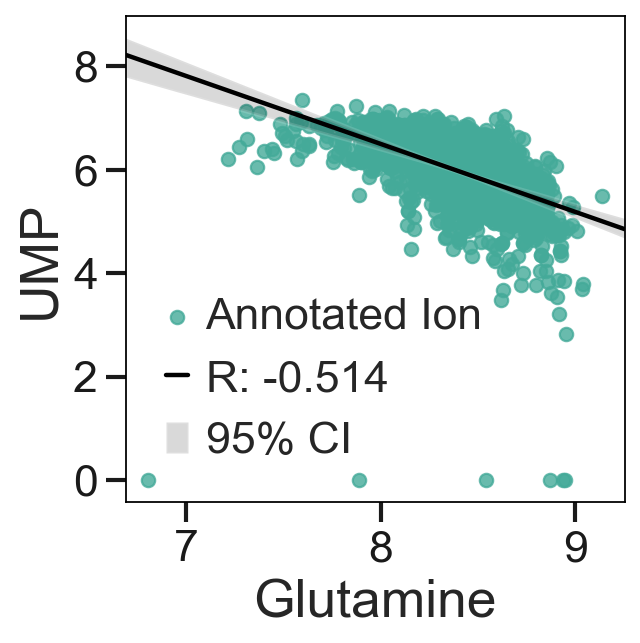

In [28]:
res = stats.pearsonr(int_matrix['C5H10N2O3-H'], 
                     int_matrix['C9H13N2O9P-H'], 
                     alternative='two-sided')

sc.set_figure_params(fontsize=15)
ax = sns.regplot(data=int_matrix, 
                 x='C5H10N2O3-H',
                 y='C9H13N2O9P-H',
                 fit_reg=True,
                 ci=95,
                 line_kws={'lw':'2', 'color':'black'},
                 scatter=True,
                 color= palette[2],
                 truncate=False)

ax.grid(False)
ax.minorticks_off()
ax.legend(labels=['Annotated Ion', f'R: {res.statistic:.3f}', '95% CI'], loc='best', fontsize=20)
plt.xlabel(xlabel=u'Glutamine', fontsize=24)
plt.ylabel(ylabel=u'UMP', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.savefig(plots_path / 'panel_G_inversely.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_G_inversely.svg', bbox_inches='tight')